# Reading general data of the problems


In [1]:
# coding=utf-8
from __future__ import division
import json
import os
import sys

from MyUtils import clean_folder, read_files
from Word2Dim import Word2Dim

dataset_path = '.' + os.sep + 'pan19-cross-domain-authorship-attribution-training-dataset-2019-01-23'
outpath = '.' + os.sep + 'dev_out'

clean_folder(outpath)

infocollection = dataset_path + os.sep + 'collection-info.json'
problems = []
language = []
with open(infocollection, 'r') as f:
    for attrib in json.load(f):
        problems.append(attrib['problem-name'])
        language.append(attrib['language'])
print('Reading general data of the problems, done!')


Reading general data of the problems, done!


# Reading problem 1

In [2]:

problem = problems[0]
index = 0

# used for n_gram extraction and word indexing, a threshold which prevent words appearing lower than this value to be counted in calculations
tf = 5


infoproblem = dataset_path + os.sep + problem + os.sep + 'problem-info.json'
candidates = []
with open(infoproblem, 'r') as f:
    fj = json.load(f)
    unk_folder = fj['unknown-folder']
    for attrib in fj['candidate-authors']:
        candidates.append(attrib['author-name'])

candidates.sort()
# Building training set
train_docs = []
for candidate in candidates:
    train_docs.extend(read_files(dataset_path + os.sep + problem, candidate))
train_texts = [text for i, (text, label) in enumerate(train_docs)]
train_labels = [label for i, (text, label) in enumerate(train_docs)]
index_2_label_dict = {i: l for i, l in enumerate(set(train_labels))}
label_2_index_dict = {l: i for i, l in enumerate(set(train_labels))}
train_labels = [label_2_index_dict[v] for v in train_labels]
w2d = Word2Dim()
train_tokenized_with_pos, train_tokenized_indexed = w2d.fit_transform_texts(train_texts, train_labels,
                                                                            language[index], tf= 5)

maxlen = len(max(train_tokenized_indexed, key=len))  # We will cut the texts after # words
embedding_dim = w2d.word_embedding.shape[1]

# preparing test set
ground_truth_file = dataset_path + os.sep + problem + os.sep + 'ground-truth.json'
gt = {}
with open(ground_truth_file, 'r') as f:
    for attrib in json.load(f)['ground_truth']:
        gt[attrib['unknown-text']] = attrib['true-author']

test_docs = read_files(dataset_path + os.sep + problem, unk_folder, gt)
test_texts = [text for i, (text, label) in enumerate(test_docs)]
test_labels = [label for i, (text, label) in enumerate(test_docs)]

# Filter validation to known authors
test_texts = [text for i, (text, label) in enumerate(test_docs) if label in label_2_index_dict.keys()]
test_labels = [label for i, (text, label) in enumerate(test_docs) if label in label_2_index_dict.keys()]

test_labels = [label_2_index_dict[v] for v in test_labels]

test_tokenized_with_pos, test_tokenized_indexed = w2d.transform(test_texts)
print("Reading problem 1, done!")

doc count to process:  63
Processing doc # 7
Processing doc # 1
Processing doc # 13
Processing doc # 14
Processing doc # 2
Processing doc # 8
Processing doc # 15
Processing doc # 9
Processing doc # 3
Processing doc # 10
Processing doc # 4
Processing doc # 11
Processing doc # 16
Processing doc # 12
Processing doc # 5
Processing doc # 19
Processing doc # 6
Processing doc # 17
Processing doc # 20
Processing doc # 25
Processing doc # 18
Processing doc # 26
Processing doc # 31
Processing doc # 21
Processing doc # 27
Processing doc # 32
Processing doc # 22
Processing doc # 28
Processing doc # 23
Processing doc # 33
Processing doc # 29
Processing doc # 24
Processing doc # 30
Processing doc # 34
Processing doc # 37
Processing doc # 35
Processing doc # 43
Processing doc # 38
Processing doc # 36
Processing doc # 39
Processing doc # 44
Processing doc # 49
Processing doc # 40
Processing doc # 45
Processing doc # 50
Processing doc # 41
Processing doc # 46
Processing doc # 51
Processing doc # 47
Pro

# Data Extraction for Neural Net



In [19]:
from MyUtils import extract_n_grams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

n = 3
vocabulary = extract_n_grams(train_docs, n, tf)
vectorizer = CountVectorizer(analyzer='char', ngram_range=(n, n), lowercase=False, vocabulary=vocabulary)
n_gram_train_data = vectorizer.fit_transform(train_texts)

n_gram_train_data = n_gram_train_data.astype(float)

for i, v in enumerate(train_texts):
    n_gram_train_data[i] = n_gram_train_data[i] / len(train_texts[i])
n_gram_test_data = vectorizer.transform(test_texts)
n_gram_test_data = n_gram_test_data.astype(float)
for i, v in enumerate(test_texts):
    n_gram_test_data[i] = n_gram_test_data[i] / len(test_texts[i])
max_abs_scaler = preprocessing.MaxAbsScaler()
scaled_train_data = max_abs_scaler.fit_transform(n_gram_train_data)
scaled_test_data = max_abs_scaler.transform(n_gram_test_data)
print("Done!")

  (0, 0)	17
  (0, 1)	8
  (0, 2)	2
  (0, 3)	2
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	6
  (0, 8)	33
  (0, 9)	27
  (0, 10)	5
  (0, 11)	23
  (0, 12)	6
  (0, 13)	2
  (0, 14)	2
  (0, 15)	8
  (0, 16)	1
  (0, 17)	10
  (0, 18)	20
  (0, 19)	19
  (0, 20)	1
  (0, 21)	5
  (0, 22)	1
  (0, 23)	1
  (0, 24)	1
  :	:
  (0, 1313)	1
  (0, 1314)	1
  (0, 1315)	1
  (0, 1316)	1
  (0, 1317)	1
  (0, 1318)	1
  (0, 1319)	1
  (0, 1321)	1
  (0, 1322)	1
  (0, 1323)	1
  (0, 1324)	1
  (0, 1325)	1
  (0, 1326)	1
  (0, 1327)	1
  (0, 1328)	1
  (0, 1588)	1
  (0, 1593)	1
  (0, 1594)	1
  (0, 1633)	1
  (0, 1660)	1
  (0, 2468)	1
  (0, 2993)	1
  (0, 3191)	1
  (0, 3200)	1
  (0, 3439)	1
Done!


In [15]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

w2d.word_embedding


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0026738 , 0.00882353, ..., 0.        , 0.        ,
        0.        ],
       [0.01388889, 0.02941176, 0.01176471, ..., 0.01809955, 0.04297994,
        0.01136364],
       ...,
       [0.05555556, 0.04812834, 0.07058824, ..., 0.0882353 , 0.04584527,
        0.0625    ],
       [0.00231481, 0.00534759, 0.        , ..., 0.00226244, 0.00573066,
        0.00284091],
       [0.        , 0.00534759, 0.00294118, ..., 0.00226244, 0.        ,
        0.00852273]], dtype=float32)

y: (?, 1019, 32) x: (?, 1019, 32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              (None, 1019)         0                                            
__________________________________________________________________________________________________
embedding_56 (Embedding)        (None, 1019, 9)      72225       words[0][0]                      
__________________________________________________________________________________________________
conv1d_98 (Conv1D)              (None, 1019, 32)     320         embedding_56[0][0]               
__________________________________________________________________________________________________
conv1d_99 (Conv1D)              (None, 1019, 32)     5152        conv1d_98[0][0]                  
___________________________________________________________________________

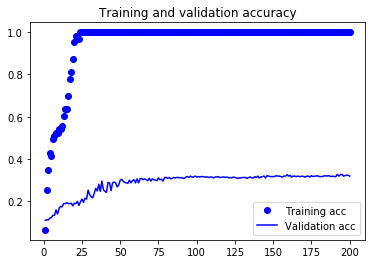

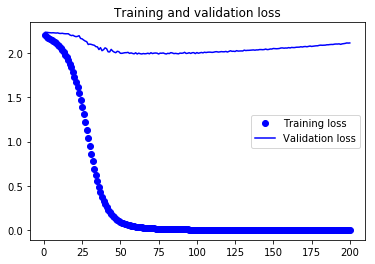

In [65]:



train_data = pad_sequences(train_tokenized_indexed, maxlen=maxlen)

test_data = pad_sequences(test_tokenized_indexed, maxlen=maxlen)

X_train, X_val, y_train, y_val = train_data, test_data, to_categorical(train_labels), to_categorical(test_labels)
# X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels,
#                                                   test_size=len(set(train_labels)), random_state=2019,
#                                                   stratify=train_labels)

# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)
# print(X_train.shape)

word_input_tensor = Input(shape=(maxlen,) , name='words')


# model = Sequential()
# model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
# model.add(layers.Conv1D(32, 1, activation='relu'))
# model.add(layers.MaxPooling1D(2))
# model.add(layers.Flatten())
# model.add(layers.Conv1D(32, 3, activation='relu'))
# model.add(layers.GlobalMaxPooling1D())
# model.add(layers.SimpleRNN(embedding_dim, dropout=0.1, recurrent_dropout=0.5, return_sequences= True))
# model.add(layers.SimpleRNN(embedding_dim))
# model.add(Dense(embedding_dim, activation='relu'))
# model.add(layers.Dense(len(set(train_labels)), activation='softmax'))
x = layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen)(word_input_tensor)
x = layers.Conv1D(32, 1, activation='relu', padding='same')(x)
# x = layers.MaxPooling1D(2)(x)
y = layers.Conv1D(32, 5, activation='relu', padding='same')(x)
# y = layers.MaxPooling1D(2)(y)
# y = layers.Conv1D(32, 3, activation='relu')(y)
# y = layers.MaxPooling1D(2)(y)
# y = layers.Conv1D(32, 5, activation='relu')(y)
# y = layers.MaxPooling1D(2)(y)
# y = layers.Conv1D(32, 5, activation='relu')(y)
# y = layers.GlobalMaxPooling1D()(y)

print('y:', y.shape, 'x:', x.shape)
added = layers.add([y, x])
answer = layers.GlobalMaxPooling1D()(added)
answer = layers.Dense(len(set(train_labels)), activation='softmax')(answer)

model = Model(word_input_tensor, answer)
model.summary()

# model.layers[0].set_weights([w2d.word_embedding])
# model.layers[0].trainable = False

model.compile(optimizer=optimizers.Adam(lr=3e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=200,
                    batch_size=1)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split



train_data = pad_sequences(train_tokenized_indexed, maxlen=maxlen)

test_data = pad_sequences(test_tokenized_indexed, maxlen=maxlen)

X_train, X_val, y_train, y_val = train_data, test_data, to_categorical(train_labels), to_categorical(test_labels)
# X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels,
#                                                   test_size=0.28, random_state=2019,
#                                                   stratify=train_labels)

# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)
word_input_tensor = Input(shape=(maxlen,) , name='words')

conv_1d_s3_model = Sequential()
conv_1d_s3_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
# conv_1d_s3_model.add(layers.Dropout(0.1))
conv_1d_s3_model.add(layers.SeparableConv1D(32, 3, activation='relu'))
conv_1d_s3_model.add(layers.GlobalMaxPooling1D())
# conv_1d_s3_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

conv_1d_s3_model.layers[0].set_weights([w2d.word_embedding])
conv_1d_s3_model.layers[0].trainable = False
word_output_tensor_0 = conv_1d_s3_model(word_input_tensor)


conv_1d_s1_model = Sequential()
conv_1d_s1_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_s1_model.add(layers.SeparableConv1D(32, 1, activation='relu'))
# conv_1d_s1_model.add(layers.MaxPooling1D(2))
# conv_1d_s1_model.add(layers.SeparableConv1D(32, 3, activation='relu'))
conv_1d_s1_model.add(layers.GlobalMaxPooling1D())
# conv_1d_s1_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

conv_1d_s1_model.layers[0].set_weights([w2d.word_embedding])
conv_1d_s1_model.layers[0].trainable = False
word_output_tensor_1 = conv_1d_s1_model(word_input_tensor)

conv_1d_complex_model = Sequential()
conv_1d_complex_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_complex_model.add(layers.SeparableConv1D(32, 2, activation='relu'))
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
# conv_1d_complex_model.add(layers.MaxPooling1D(2))
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
# conv_1d_complex_model.add(layers.SeparableConv1D(128, 3, activation='relu'))
# conv_1d_complex_model.add(layers.MaxPooling1D(2))
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
# conv_1d_complex_model.add(layers.SeparableConv1D(128, 3, activation='relu'))
conv_1d_complex_model.add(layers.GlobalAveragePooling1D())
# conv_1d_s1_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

conv_1d_complex_model.layers[0].set_weights([w2d.word_embedding])
conv_1d_complex_model.layers[0].trainable = False
word_output_tensor_2 = conv_1d_complex_model(word_input_tensor)

concatenated = layers.concatenate([word_output_tensor_0, word_output_tensor_1
                                   , word_output_tensor_2
                                  ], axis=-1)
# concatenated = layers.Dense(32, activation='relu')(concatenated)
answer = layers.Dense(len(set(train_labels)), activation='softmax')(concatenated)

model = Model(word_input_tensor, answer)
model.summary()

# model.layers[0].set_weights([w2d.word_embedding])
# model.layers[0].trainable = False

model.compile(optimizer=optimizers.Adam(lr=3e-4),
              loss='mae',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=2000,
                    batch_size=1)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              (None, 1019)         0                                            
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 32)           12083       words[0][0]                      
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 32)           12065       words[0][0]                      
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 32)           12074       words[0][0]                      
__________________________________________________________________________________________________
concatenat

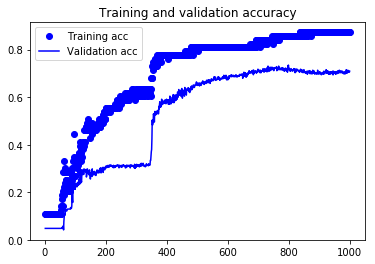

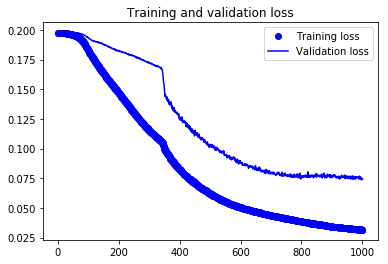

In [22]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()